# SARIMAX Model

(Sourced: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

SARIMAX includes an external predictor, also called, ‘exogenous variable’ into the SARIMA model.

**The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well**.

For the sake of demonstration, I am going to use the seasonal index from the classical seasonal decomposition on the latest 36 months of data. Why the seasonal index? Isn’t SARIMA already modeling the seasonality? That is correct.

But also, I want to see how the model looks if we force the recent seasonality pattern into the training and forecast.

Secondly, this is a good variable for demo purpose. So you can use this as a template and plug in any of your variables into the code. The seasonal index is a good exogenous variable because it repeats every frequency cycle, 12 months in this case.

So, you will always know what values the seasonal index will hold for the future forecasts.


## Import libraries

In [1]:
pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use("seaborn-whitegrid")

## Load data

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


## Plot time series

In [4]:
def plot_time_series(df, x, y, title="", xlabel="", ylabel="", color=""):
  plt.figure(figsize=(16,8))
  plt.plot(x, y, color=color)
  plt.title(title, fontsize=18)
  plt.xlabel(xlabel, fontsize=18)
  plt.ylabel(ylabel, fontsize=18)
  plt.show()

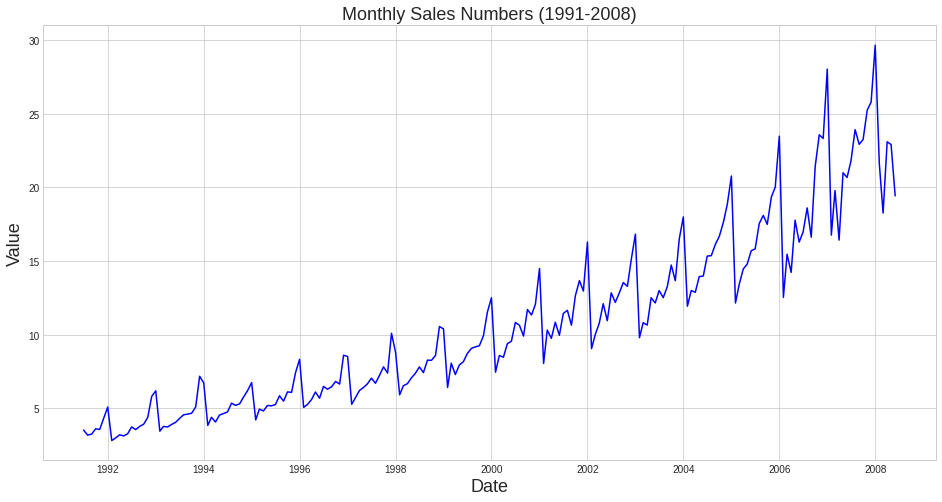

In [5]:
plot_time_series(data, x=data.index, y=data.loc[:, "value"], title="Monthly Sales Numbers (1991-2008)", xlabel="Date", ylabel="Value", color="blue")

## Compute seasonal index

Let’s compute the seasonal index so that it can be forced as a (exogenous) predictor to the SARIMAX model.

In [6]:
# multiplicative seasonal component
result_mul = seasonal_decompose(data['value'][-36:],   # 3 years
                                model='multiplicative', 
                                extrapolate_trend='freq')
result_mul.seasonal

date
2005-07-01    0.970490
2005-08-01    1.050900
2005-09-01    0.998881
2005-10-01    1.059657
2005-11-01    1.146141
2005-12-01    1.150750
2006-01-01    1.316913
2006-02-01    0.803279
2006-03-01    0.850667
2006-04-01    0.832227
2006-05-01    0.954751
2006-06-01    0.865344
2006-07-01    0.970490
2006-08-01    1.050900
2006-09-01    0.998881
2006-10-01    1.059657
2006-11-01    1.146141
2006-12-01    1.150750
2007-01-01    1.316913
2007-02-01    0.803279
2007-03-01    0.850667
2007-04-01    0.832227
2007-05-01    0.954751
2007-06-01    0.865344
2007-07-01    0.970490
2007-08-01    1.050900
2007-09-01    0.998881
2007-10-01    1.059657
2007-11-01    1.146141
2007-12-01    1.150750
2008-01-01    1.316913
2008-02-01    0.803279
2008-03-01    0.850667
2008-04-01    0.832227
2008-05-01    0.954751
2008-06-01    0.865344
Name: seasonal, dtype: float64

In [7]:
# seasonal index
seasonal_index = result_mul.seasonal[-12:].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
seasonal_index

,seasonal,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


In [8]:
# merge with the base data
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index  # reassign the index.
df

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141
...,...,...,...
2008-02-01,21.654285,2,0.803279
2008-03-01,18.264945,3,0.850667
2008-04-01,23.107677,4,0.832227


In [9]:
df.iloc[0:12]

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141
1991-12-01,4.306371,12,1.150750
1992-01-01,5.088335,1,1.316913
1992-02-01,2.814520,2,0.803279
1992-03-01,2.985811,3,0.850667


In [10]:
df.iloc[12:24]

,value,month,seasonal_index
date,,,
1992-07-01,3.737851,7,0.970490
1992-08-01,3.558776,8,1.050900
1992-09-01,3.777202,9,0.998881
1992-10-01,3.924490,10,1.059657
1992-11-01,4.386531,11,1.146141
1992-12-01,5.810549,12,1.150750
1993-01-01,6.192068,1,1.316913
1993-02-01,3.450857,2,0.803279
1993-03-01,3.772307,3,0.850667


## Build SARIMAX Model

The exogenous variable (seasonal index) is ready. Let’s build the SARIMAX model.

In [11]:
# SARIMAX Model
sxmodel = pm.auto_arima(df[['value']], exogenous=df[['seasonal_index']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=536.818, Time=1.84 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=626.061, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=598.068, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=613.475, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=759.274, Time=0.13 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=561.407, Time=0.41 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=538.817, Time=4.05 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=545.106, Time=1.54 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=539.549, Time=5.53 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=596.467, Time=0.44 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=531.829, Time=1.50 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=557.198, Time=0.48 sec
 ARIMA(2,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(2,0,1)(0,1,2)[12] intercept   : AI

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  204
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -254.176
Date:                                 Wed, 18 Aug 2021   AIC                            524.352
Time:                                         09:02:13   BIC                            550.412
Sample:                                     07-01-1991   HQIC                           534.907
                                          - 06-01-2008                                         
Covariance Type:                                   opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
seasonal_index  -8.82e-06   2.76e+04   -3.2e-10      1.000    -5.4e+04     5.4e+04
ar.L1              0.6750      0.069      9.744      0.000       0.539       0.811
ar.L2              0.3149      0.064      4.923      0.000       0.190       0.440
ma.L1             -0.6390      0.063    -10.124      0.000      -0.763      -0.515
ar.S.L12           0.8484      0.152      5.572      0.000       0.550       1.147
ma.S.L12          -1.5857      0.174     -9.122      0.000      -1.926      -1.245
ma.S.L24           0.7618      0.110      6.946      0.000       0.547       0.977
sigma2             0.7455      0.068     10.924      0.000       0.612       0.879
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               197.88
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):              15.44   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We have effectively forced the latest seasonal effect of the latest 3 years into the model instead of the entire history.

Alright let’s forecast into the next 24 months. For this, you need the value of the seasonal index for the next 24 months.

## Forecast

In [12]:
# Forecast
n_periods = 24
fitted, confint = sxmodel.predict(n_periods=n_periods, 
                                  exogenous=np.tile(seasonal_index.seasonal, 2).reshape(-1,1), 
                                  return_conf_int=True)

index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

In [13]:
# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

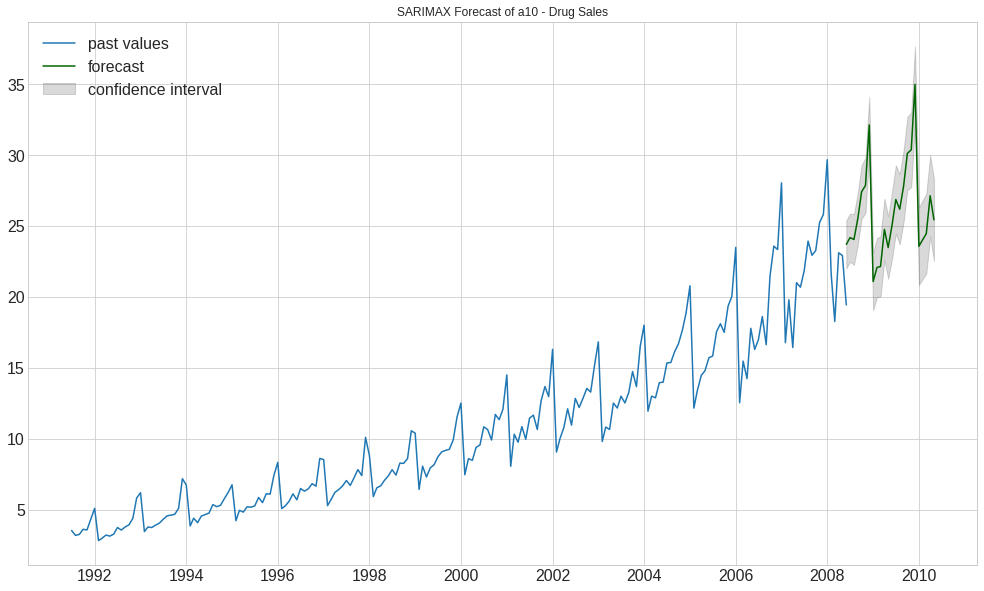

In [14]:
# Plot
plt.figure(figsize=(17,10))
plt.plot(data['value'], label="past values")
plt.plot(fitted_series, color='darkgreen', label="forecast")
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15, label="confidence interval")

plt.title("SARIMAX Forecast of a10 - Drug Sales")
plt.legend(loc='upper left', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()